<a href="https://colab.research.google.com/github/Rakshit-Sawarn-iitb/Tumor-Classification/blob/main/TumorClassificationFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Loading**

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
training_dir = '/content/drive/MyDrive/Training'
testing_dir = '/content/drive/MyDrive/Testing'

In [ ]:
import os
train_paths = []
train_labels = []

for label in ['notumor', 'pituitary', 'meningioma', 'glioma']:
  for dirname, _, filenames in os.walk(os.path.join(training_dir,label)):
        for filename in filenames:
            train_paths.append(os.path.join(dirname, filename))
            train_labels.append(label)

len(train_paths), len(train_labels)

(5732, 5732)

In [ ]:
test_paths = []
test_labels = []

for label in ['notumor', 'pituitary', 'meningioma', 'glioma']:
  for dirname, _, filenames in os.walk(os.path.join(testing_dir,label)):
        for filename in filenames:
            test_paths.append(os.path.join(dirname, filename))
            test_labels.append(label)

len(test_paths), len(test_labels)

(1311, 1311)

# **Data Processing and Pre-processing of images**

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
from PIL import Image
import matplotlib.pyplot as plt

label_mapping = {'notumor': 0, 'pituitary': 1, 'meningioma': 2, 'glioma': 3}

class TumorDataset(Dataset):

  def __init__(self, paths, labels, label_mapping, augmentations=None):
    self.paths = paths
    self.labels = labels
    self.label_mapping = label_mapping
    if augmentations is None:
      self.augmentations = transforms.Compose([transforms.ToTensor()])

    else:
      self.augmentations = augmentations

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index):
    label = self.labels[index]

    sample = Image.open(self.paths[index]).convert('L')
    sample = self.augmentations(sample)

    numerical_label = self.label_mapping[label]
    return sample, numerical_label

In [ ]:
train_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((240,240)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_augmentations = transforms.Compose([
    transforms.Resize((240,240)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = TumorDataset(train_paths, train_labels,label_mapping, train_augmentations)
test_dataset = TumorDataset(test_paths, test_labels,label_mapping, test_augmentations)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

tensor([[[-0.9922, -0.9922, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9843, -0.9843, -0.9843,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.9922, -0.9843, -0.9843,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -0.9922, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -0.9922, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]])
1


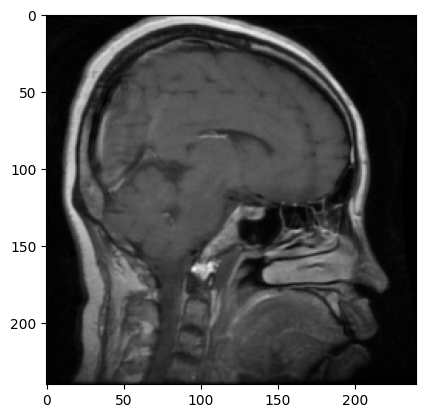

In [ ]:
random_sample, random_label = test_dataset[500]
print(random_sample)
plt.imshow(random_sample.squeeze(), cmap='gray')
print(random_label)

# **Model**

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import timm
model = timm.create_model("xception", pretrained=True)
import torch.nn as nn
import torch.optim as optim
# Modify the first convolutional layer to accept single-channel input
original_conv = model.conv1
model.conv1 = nn.Conv2d(
    in_channels=1,  # Change to 1 for single-channel input
    out_channels=original_conv.out_channels,
    kernel_size=original_conv.kernel_size,
    stride=original_conv.stride,
    padding=original_conv.padding,
    bias=original_conv.bias
)

# If you want to initialize the new single-channel weights using the mean of the RGB weights
with torch.no_grad():
    model.conv1.weight[:, 0, :, :] = original_conv.weight.mean(dim=1)

# Check the number of input features to the final fully connected layer
in_features = model.fc.in_features

# Replace the final fully connected layer with a new one for binary classification
model.fc = nn.Linear(in_features, 4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Xception(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

# **Training**

In [ ]:
class Config:
  learning_rate = 1e-4
  epochs = 10

In [ ]:
import gc
class Trainer:
    def __init__(self, model, dataloaders, Config):
        self.model = model.to(device)
        self.train, self.test = dataloaders
        self.Config = Config
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.Config.learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
        return (preds == labels).sum().item() / labels.shape[0]

    def train_one_epoch(self):
        running_loss = 0
        running_acc = 0

        for X, y in self.train:
            X = X.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.long)  # Ensure labels are long for CrossEntropyLoss

            self.optim.zero_grad()
            outputs = self.model(X)

            loss = self.loss_fn(outputs, y)
            loss.backward()
            self.optim.step()

            running_loss += loss.item()
            running_acc += self.accuracy(outputs, y)

            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()

        train_loss = running_loss / len(self.train)
        train_acc = running_acc / len(self.train)

        return train_loss, train_acc

    def fit(self):
        losses = []
        accuracies = []


        for epoch in range(self.Config.epochs):
            self.model.train()
            train_loss, train_acc = self.train_one_epoch()
            losses.append(train_loss)
            accuracies.append(train_acc)
            print(f"EPOCH {epoch+1}/{self.Config.epochs}")
            print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc}\n\n")

    @torch.no_grad()
    def inference(self):
        self.model.eval()
        running_acc = 0

        for X, y in self.test:
            X = X.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.long)  # Ensure labels are long for CrossEntropyLoss
            outputs = self.model(X)
            running_acc += self.accuracy(outputs, y)

            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()

        accuracy = (running_acc / len(self.test)) * 100
        return accuracy

    def predict(self, input_image):
        self.model.eval()
        input_image = input_image.to(device, dtype=torch.float)
        output = self.model(input_image)

        _, predicted_class = torch.max(output, 1)  # Get the index of the max log-probability
        return predicted_class.item()

In [ ]:
trainer = Trainer(model, (train_dataloader, test_dataloader), Config)
trainer.fit()

EPOCH 1/10
Training Loss: 0.3472236424063643 | Training Accuracy: 0.8904513888888889


EPOCH 2/10
Training Loss: 0.09686036460722486 | Training Accuracy: 0.9689236111111111


EPOCH 3/10
Training Loss: 0.05847578930099391 | Training Accuracy: 0.9810763888888889


EPOCH 4/10
Training Loss: 0.04031922983025046 | Training Accuracy: 0.9873263888888889


EPOCH 5/10
Training Loss: 0.027509608670111953 | Training Accuracy: 0.9920138888888889


EPOCH 6/10
Training Loss: 0.030148184686873317 | Training Accuracy: 0.990625


EPOCH 7/10
Training Loss: 0.027398034387604436 | Training Accuracy: 0.9909722222222223


EPOCH 8/10
Training Loss: 0.01885798725998029 | Training Accuracy: 0.9947916666666666


EPOCH 9/10
Training Loss: 0.02028848211048171 | Training Accuracy: 0.9932291666666667


EPOCH 10/10
Training Loss: 0.012994702526096564 | Training Accuracy: 0.9954861111111111




In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Tumormodel2.pth')
print("Model saved successfully!!")

Model saved successfully!!


In [ ]:
@torch.no_grad()
def calculate_test_accuracy(model, test_loader, device):
    model.eval()
    running_corrects = 0
    total_samples = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels)
        total_samples += labels.size(0)

        del inputs
        del labels
        gc.collect()
        torch.cuda.empty_cache()

    test_accuracy = running_corrects / total_samples
    return test_accuracy.item()

In [ ]:
test_accuracy = calculate_test_accuracy(model, test_dataloader, device)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.991609513759613


# **Testing**

Meningioma Detected


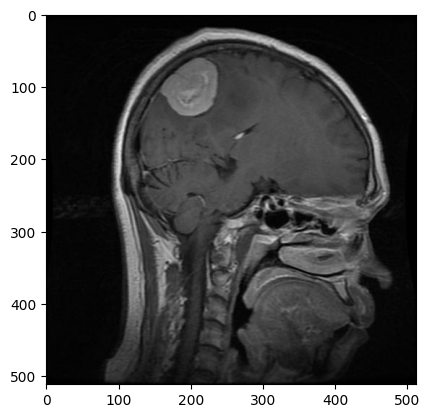

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Tumormodel2.pth'))
model.eval()

transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

image_path = '/content/drive/MyDrive/Te-me_0279.jpg'
image = Image.open(image_path)
input_data = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_data)

probabilities = torch.softmax(output, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

if(predicted_class==0):
  print("No Tumor Detected")
elif(predicted_class==1):
  print("Pituitary Detected")
elif(predicted_class==2):
  print("Meningioma Detected")
elif(predicted_class==3):
  print("Glioma Detected")

plt.imshow(image, cmap='gray')